# 0.1 Settings and Importing Modules

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pprint
from sklearn.metrics import mean_squared_error
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
%matplotlib inline



# 0.2 Loading Data

In [3]:
df=pd.read_csv('../Datasets/result_5_tags.csv', header=None)
dfk=pd.read_csv('../Datasets/result_5_tags.csv', header=None)
columns= ['Title', 'Platform', 'Reviews', 'Positives', 'Review_Summary', 'Released', 'OriginalPrice', 'DiscountPercentage', 'AfterDiscount', 'Main_Tag', 'url', 'All_Tags']
df.columns=columns
dfk.columns=columns
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
pd.set_option('display.max_rows', 150)

# 1.1 Cleaning Data
### With some baseline Feature Engineering (F.E.)

In [4]:
# Check entries
df.tail(1)

,Title,Platform,Reviews,Positives,Review_Summary,Released,OriginalPrice,DiscountPercentage,AfterDiscount,Main_Tag,url,All_Tags
14805,The Explorer (Demo) Demo,Win,nan,0,None,"Jan 31, 2020",Free Demo,nan,0.00,Action,https://store.steampowered.com/app/1184980/The...,"Action, Adventure, Free to Play, Massively Mul..."


In [5]:
df.shape

(14806, 12)

In [6]:
# Drop games that doesn't have a price
df = df.dropna()

In [7]:
# Drop games that have an upcoming dates
pattern = '\w+\s\d+,\s\d+'
df[df['Released'].str.contains(pattern, na=False)]

,Title,Platform,Reviews,Positives,Review_Summary,Released,OriginalPrice,DiscountPercentage,AfterDiscount,Main_Tag,url,All_Tags
0,Mount & Blade II: Bannerlord,Win,65158.00,87,Very Positive,"Mar 30, 2020",49.99,-10.00,44.99,Early Access,https://store.steampowered.com/app/261550/Moun...,"Early Access, Medieval, Strategy, Open World, RPG"
2,Planet Zoo,Win,21555.00,87,Very Positive,"Nov 5, 2019",44.99,-25.00,33.74,Simulation,https://store.steampowered.com/app/703080/Plan...,"Simulation, Strategy, Building, Management, Sa..."
3,Sid Meier’s Civilization® VI,"Win, Mac, Linux",68529.00,79,Mostly Positive,"Oct 20, 2016",59.99,-70.00,17.99,Strategy,https://store.steampowered.com/app/289070/Sid_...,"Strategy, Turn-Based Strategy, Historical, Mul..."
7,Black Desert Online,Win,22877.00,73,Mostly Positive,"May 24, 2017",9.99,-50.00,4.99,MMORPG,https://store.steampowered.com/app/582660/Blac...,"MMORPG, Massively Multiplayer, RPG, Open World..."
12,Planet Coaster,Win,28794.00,88,Very Positive,"Nov 17, 2016",44.99,-75.00,11.24,Simulation,https://store.steampowered.com/app/493340/Plan...,"Simulation, Building, Management, Sandbox, Sin..."
...,...,...,...,...,...,...,...,...,...,...,...,...
14407,Jigsaw Puzzle Pack - Pixel Puzzles Ultimate: P...,Win,1.00,0,None,"Mar 21, 2017",7.99,-65.00,2.79,Strategy,https://store.steampowered.com/app/591497/Jigs...,"Strategy, Action, Adventure, Free to Play, Indie"
14413,Jigsaw Puzzle Pack - Pixel Puzzles Ultimate: A...,Win,1.00,0,None,"Oct 21, 2016",2.99,-59.00,1.22,Action,https://store.steampowered.com/app/502842/Jigs...,"Action, Adventure, Casual, Indie, Simulation"
14466,Jigsaw Puzzle Pack - Pixel Puzzles Ultimate: J...,Win,1.00,0,None,"Oct 4, 2016",3.99,-57.00,1.71,Action,https://store.steampowered.com/app/467260/Jigs...,"Action, Indie, Casual, Sports, Strategy"
14661,DragonScales 5: The Frozen Tomb,"Win, Mac",1.00,0,None,"Nov 20, 2018",9.99,-50.00,4.99,Casual,https://store.steampowered.com/app/971640/Drag...,"Casual, Match 3, Puzzle, Sequel, Dragons"


In [8]:
# Convert 'Released' column to datetime data type
df['Released'] = pd.to_datetime(df['Released'], format="%b %d, %Y")

##### F.E. 0.1: Release Date to Release Season

In [9]:
# Define and call function to convert dates to seasons
def season_of_date(date):
    year = str(date.year)
    seasons = {'Spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'Summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'Autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['Spring']:
        return 1
    if date in seasons['Summer']:
        return 2
    if date in seasons['Autumn']:
        return 3
    else:
        return 4
    
df['Season'] = df.Released.map(season_of_date)

##### F.E. 0.2: Release Date to Days_Since_Release

In [10]:
# Add a new column called "Days_Since_Release" to see how old a game really is in terms of days
df['Days_Since_Release'] = (pd.to_datetime('today') - df['Released']).astype('timedelta64[D]')

In [11]:
# Making sure all data types are correct before further processing
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 0 to 14692
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Title               527 non-null    object        
 1   Platform            527 non-null    object        
 2   Reviews             527 non-null    float64       
 3   Positives           527 non-null    int64         
 4   Review_Summary      527 non-null    object        
 5   Released            527 non-null    datetime64[ns]
 6   OriginalPrice       527 non-null    object        
 7   DiscountPercentage  527 non-null    float64       
 8   AfterDiscount       527 non-null    float64       
 9   Main_Tag            527 non-null    object        
 10  url                 527 non-null    object        
 11  All_Tags            527 non-null    object        
 12  Season              527 non-null    int64         
 13  Days_Since_Release  527 non-null    float64     

In [12]:
df.describe()

,Reviews,Positives,DiscountPercentage,AfterDiscount,Season,Days_Since_Release
count,527.00,527.00,527.00,527.00,527.00,527.00
mean,873.58,53.24,-53.39,4.99,2.48,1085.01
std,4883.33,37.58,21.65,5.99,1.09,996.96
min,1.00,0.00,-100.00,0.00,1.00,7.00
25%,6.00,0.00,-75.00,1.39,2.00,358.50
50%,38.00,69.00,-50.00,2.99,2.00,801.00
75%,203.00,85.00,-35.00,6.44,3.00,1562.00
max,68529.00,100.00,-8.00,49.99,4.00,5184.00


Two ways of removing outliers, if needed

In [13]:
# sets the boundaries for the outliers according to the 1.5 * IQR rule
# q1 = df.Reviews.describe()['25%']
# q3 = df.Reviews.describe()['75%']

# upper = q3 + 6*(q3 - q1) 
# lower = q1 - 6*(q3 - q1)

# df = df[(df.Reviews < upper) & (df.Reviews > lower)]

In [14]:
# df = df[df.Reviews > 30]

##### F.E. 0.3: Platform (Win, Mac, Linux, etc) to new dummy Multiplatform (1 or 0)

In [15]:
# Creates a new categorical column 'Multiplatform' based on scraped 'Platform' data, if it is multiplatform then int 1 will be given, otherwise 0
df['Multiplatform'] = np.where(df['Platform'].str.contains(','), 1, 0)

In [16]:
# Removing '-' sign in the 'DiscountPercentage' column
df['DiscountPercentage'] = df['DiscountPercentage'].astype(str)
df['DiscountPercentage'] = df['DiscountPercentage'].replace('-', '', regex=True)
df['DiscountPercentage'] = df['DiscountPercentage'].astype(float)

In [17]:
# Checking how many games that has a price
df.shape

(527, 15)

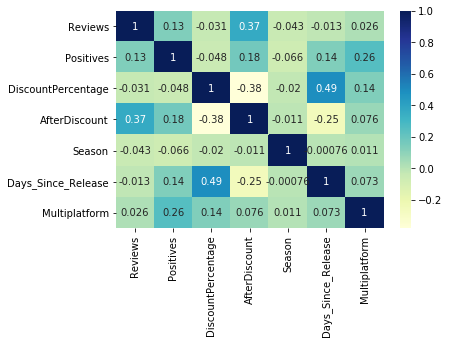

In [18]:
# Heat map to check if there is any outstanding correlation
correlation = df.corr() #corr() method of pandas library calculates correlation between columns of dataframe
sns.heatmap(correlation,cmap="YlGnBu",annot=True)
plt.show()

##### Compiled function to check for R^2 score for all models to come

In [19]:
def RSquare(df, col):
    X, y = df.drop(col,axis=1), df[col]

    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    X, y = np.array(X), np.array(y)
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 50)
    cv_lm_r2s, cv_lm_reg_r2s, cv_lm_poly_r2s, cv_lasso_r2s = [], [], [], [] #collect the validation results for both models

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        #simple linear regression
        lm = LinearRegression()
        lm_reg = Ridge(alpha=1)
        lm_poly = LinearRegression()

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
#         cv_lm_r2s.append(lm.score(X_tra, y_tra))

        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        lm_reg.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

        poly = PolynomialFeatures(degree=2) 
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
        lm_poly.fit(X_train_poly, y_train)
        cv_lm_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
        
        #Lasso
        std = StandardScaler()
        std.fit(X_train)
        
        X_tr = std.transform(X_train)
        X_te = std.transform(X_test)
        
        X_val_lasso = std.transform(X_val)
        
        alphavec = 10**np.linspace(-10,10,1000)

        lasso_model = LassoCV(alphas = alphavec, cv=5)
        lasso_model.fit(X_tr, y_train)
        cv_lasso_r2s.append(lasso_model.score(X_val_lasso, y_val))
        
        test_set_pred = lasso_model.predict(X_te)
        
        column = df.drop(col,axis=1)
        to_print = list(zip(column.columns, lasso_model.coef_))
        pp = pprint.PrettyPrinter(indent = 1)
    
        rms = sqrt(mean_squared_error(y_test, test_set_pred))
        
    print('Simple regression scores: ', cv_lm_r2s, '\n')
    print('Ridge scores: ', cv_lm_reg_r2s, '\n')
    print('Poly scores: ', cv_lm_poly_r2s, '\n')
    print('Lasso scores: ', cv_lasso_r2s, '\n')

    print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
    print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
    print(f'Poly mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}', '\n')
    
    print('lasso_model.alpha_:', lasso_model.alpha_)
    print(f'Lasso cv r^2: {r2_score(y_test, test_set_pred):.3f} +- {np.std(cv_lasso_r2s):.3f}', '\n')
    
    print(f'MAE: {mae(y_test, test_set_pred)}', '\n')
    print('RMSE:', rms, '\n')
    
    print('Lasso Coef:')
    pp.pprint (to_print)

In [20]:
# 'Mean absolute error'
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

##### Compiled function to plot feature-target relationships for all models to come

In [33]:
def plotting(df, col):
    features=df.columns
    for i in features:
        sns.lmplot(x=i, y=col, data=df,line_kws={'color': 'red'}, height = 6, aspect = 2)
        text="Relation between " + col + " and " + i 
        plt.title(text, weight = 'bold', pad='40').set_fontsize('15')
        plt.xlabel(i, weight='bold', fontsize='10', labelpad=20)
        plt.ylabel(col, fontsize='10', weight='bold', labelpad=20)

    #     plt.savefig(i+'.png', format = 'png', bbox_inches='tight', dpi = 320);
        plt.show()

# 2.1 F.E. and Modeling - Round 1: 
### Remove Floor Outliers and Building Baseline Model
Review count > 30

In [22]:
# Copy from cleaned baseline dataframe
df1 = df.copy()

In [23]:
# Setting a floor limit of 30
df1 = df1[df1.Reviews > 30]
df1 = df1[(df1.Positives != 0)]

In [24]:
# Drop unquantifiable features
df1.drop(['Title', 'Main_Tag', 'All_Tags', 'url', 'Released', 'AfterDiscount', 'Review_Summary', 'Platform'], axis=1, inplace = True)

##### EDA

In [25]:
# Check to see how many entries we will be modeling with
df1.shape

(287, 7)

In [27]:
df1.head()

,Reviews,Positives,OriginalPrice,DiscountPercentage,Season,Days_Since_Release,Multiplatform
0,65158.00,87,49.99,10.00,1,19.00,0
2,21555.00,87,44.99,25.00,3,165.00,0
3,68529.00,79,59.99,70.00,3,1276.00,1
7,22877.00,73,9.99,50.00,1,1060.00,0
12,28794.00,88,44.99,75.00,3,1248.00,0


In [28]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 0 to 6983
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Reviews             287 non-null    float64
 1   Positives           287 non-null    int64  
 2   OriginalPrice       287 non-null    object 
 3   DiscountPercentage  287 non-null    float64
 4   Season              287 non-null    int64  
 5   Days_Since_Release  287 non-null    float64
 6   Multiplatform       287 non-null    int32  
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 16.8+ KB


In [29]:
df1.describe()

,Reviews,Positives,DiscountPercentage,Season,Days_Since_Release,Multiplatform
count,287.00,287.00,287.00,287.00,287.00,287.00
mean,1596.49,76.49,55.18,2.36,1323.06,0.45
std,6535.03,16.67,21.87,1.08,1119.61,0.50
min,31.00,11.00,10.00,1.00,8.00,0.00
25%,62.50,68.00,40.00,1.00,442.50,0.00
50%,173.00,79.00,50.00,2.00,1058.00,0.00
75%,534.50,89.50,75.00,3.00,1846.50,1.00
max,68529.00,100.00,90.00,4.00,5184.00,1.00


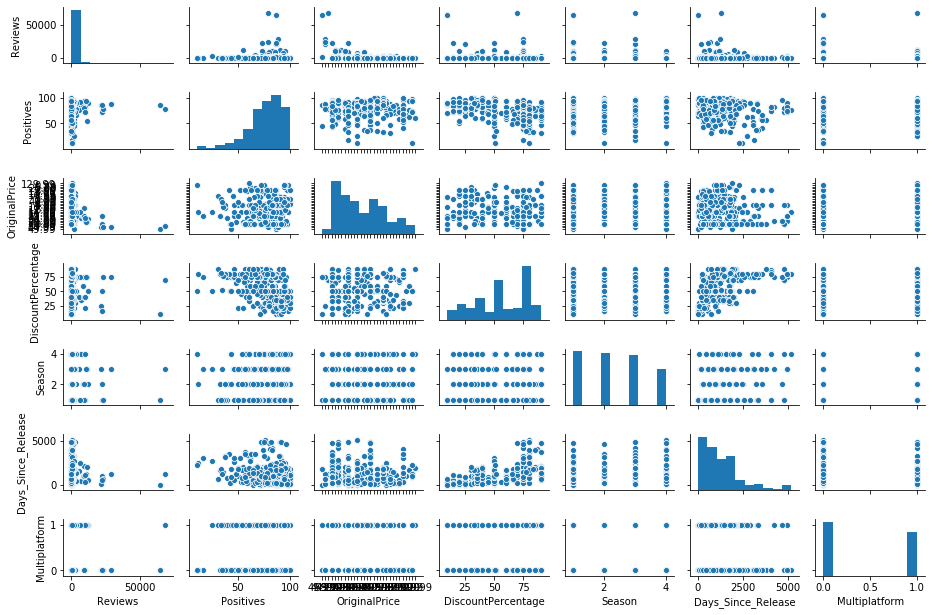

In [30]:
# Pairplotting to see outstanding correlations
sns.pairplot(df1, height=1.2, aspect=1.5);

##### Modeling

In [31]:
# Modeling using existing data, note that the best score is lasso in this case. 
RSquare(df1,'DiscountPercentage')
# Also examine the lasso coefficients below to decide next steps.

Simple regression scores:  [0.43430648681928696, 0.3389199828886237, 0.18420067669233053, 0.39897744592671086, 0.354147191088465] 

Ridge scores:  [0.4337016994378908, 0.3399137788928409, 0.18497491000373079, 0.3994298350105554, 0.3543038983675187] 

Poly scores:  [0.5060011063006531, 0.37238725012111334, 0.08045038909119562, 0.04300483768392982, 0.26638750427135016] 

Lasso scores:  [0.4343064868206956, 0.34800002416038567, 0.22365367047103946, 0.4068608079819587, 0.34246940502064316] 

Simple mean cv r^2: 0.342 +- 0.086
Ridge mean cv r^2: 0.342 +- 0.085
Poly mean cv r^2: 0.254 +- 0.175 

lasso_model.alpha_: 0.9772146969725725
Lasso cv r^2: 0.419 +- 0.073 

MAE: 12.76497338985648 

RMSE: 16.32212077999273 

Lasso Coef:
[('Reviews', -0.0),
 ('Positives', -3.6453316485877485),
 ('OriginalPrice', 0.1138184761171979),
 ('Season', -0.28208204032610396),
 ('Days_Since_Release', 11.305642208200558),
 ('Multiplatform', 2.3271916993896946)]


##### Plotting

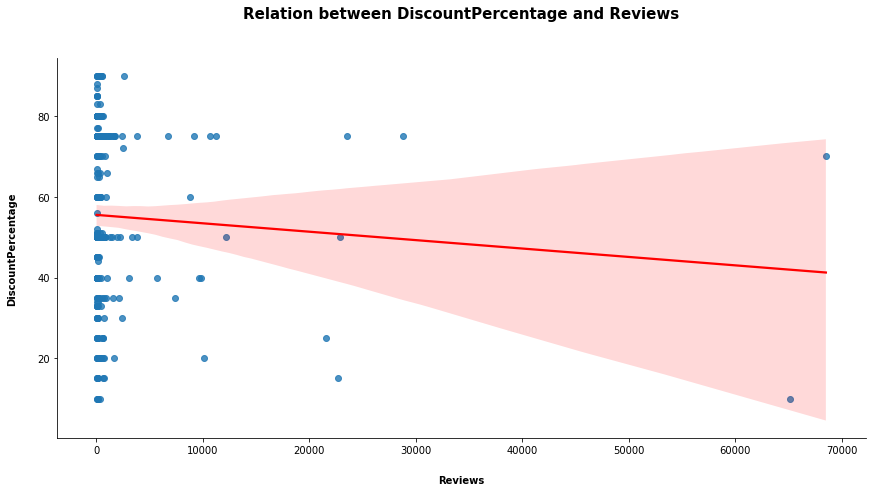

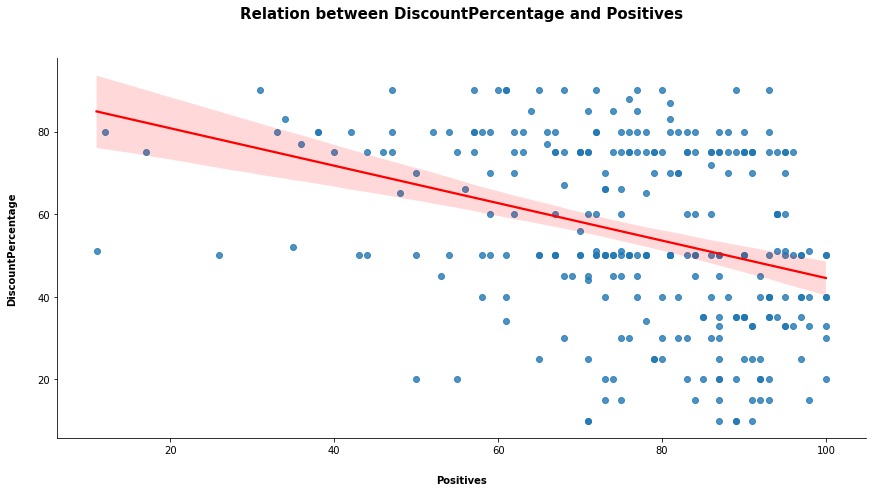

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

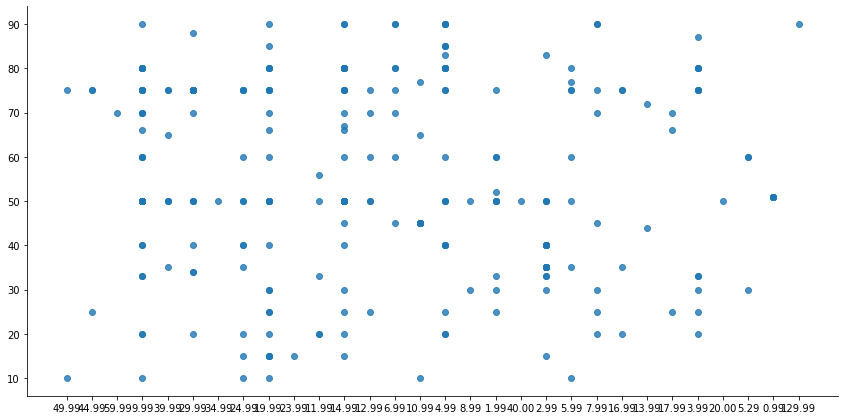

In [34]:
plotting(df1, 'DiscountPercentage')

# 2.2 F.E. and Modeling - Round 2: 
### Log Transformation based on previous pairplots
Features affected: 'Reviews' & 'OriginalPrice'

In [35]:
# Copy from df1 to inherit changes made
df2 = df1.copy()

In [43]:
# Log transforming because of skewed pairplot graphs
df2.Reviews = np.log(df2.Reviews)
df2.OriginalPrice = df2.OriginalPrice.astype(float)
df2.OriginalPrice = np.log(df2.OriginalPrice)

##### EDA

In [44]:
df2.describe()

,Reviews,Positives,OriginalPrice,DiscountPercentage,Season,Days_Since_Release,Multiplatform
count,287.00,287.00,287.00,287.00,287.00,287.00,287.00
mean,1.65,76.49,2.29,55.18,2.36,1323.06,0.45
std,0.28,16.67,0.88,21.87,1.08,1119.61,0.50
min,1.23,11.00,-0.01,10.00,1.00,8.00,0.00
25%,1.42,68.00,1.61,40.00,1.00,442.50,0.00
50%,1.64,79.00,2.30,50.00,2.00,1058.00,0.00
75%,1.84,89.50,3.00,75.00,3.00,1846.50,1.00
max,2.41,100.00,4.87,90.00,4.00,5184.00,1.00


In [45]:
df2.head()

,Reviews,Positives,OriginalPrice,DiscountPercentage,Season,Days_Since_Release,Multiplatform
0,2.41,87,3.91,10.00,1,19.00,0
2,2.30,87,3.81,25.00,3,165.00,0
3,2.41,79,4.09,70.00,3,1276.00,1
7,2.31,73,2.30,50.00,1,1060.00,0
12,2.33,88,3.81,75.00,3,1248.00,0


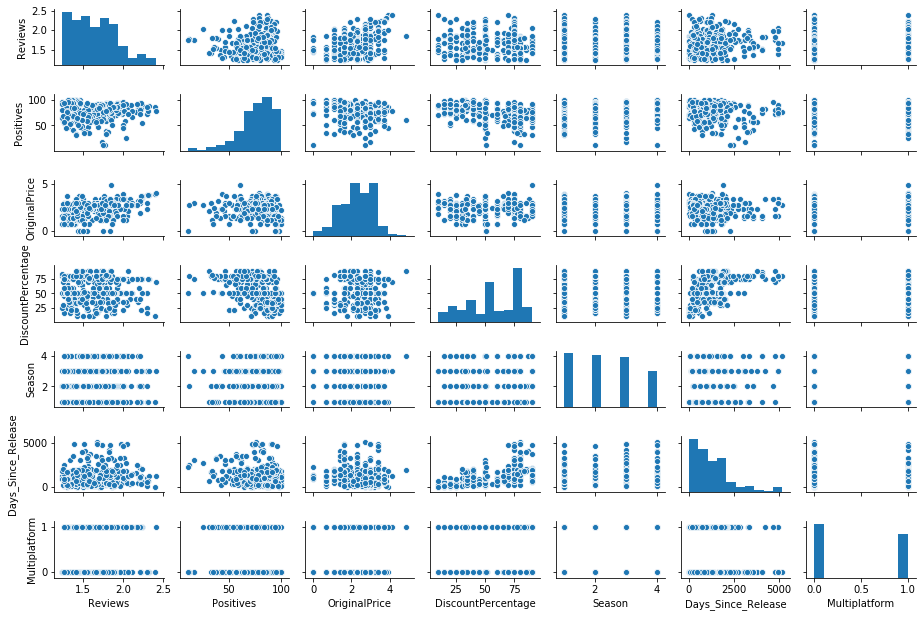

In [46]:
# Pairplotting to see outstanding correlations
sns.pairplot(df2, height=1.2, aspect=1.5);

##### Modeling

In [47]:
RSquare(df2, 'DiscountPercentage')

# Notice that even though this model has a slightly better score than the baseline model, the error margin also doubled.

Simple regression scores:  [0.49141952085047846, 0.36122604452749457, 0.17285307686002416, 0.42449921053456113, 0.3600985001835629] 

Ridge scores:  [0.49023947183145555, 0.3618765707351588, 0.1746328544462714, 0.42487203292306347, 0.3603192064007188] 

Poly scores:  [0.4124593722084591, 0.3835111628184765, 0.22296081463236284, 0.1700306382262342, 0.3474103091269981] 

Lasso scores:  [0.48186795949881245, 0.36122604452671375, 0.17285307686598872, 0.4244992105346811, 0.3600985001833544] 

Simple mean cv r^2: 0.362 +- 0.106
Ridge mean cv r^2: 0.362 +- 0.105
Poly mean cv r^2: 0.307 +- 0.094 

lasso_model.alpha_: 1e-10
Lasso cv r^2: 0.437 +- 0.104 

MAE: 12.305201620188688 

RMSE: 16.07420732067234 

Lasso Coef:
[('Reviews', -2.3193572976142995),
 ('Positives', -3.879340249204339),
 ('OriginalPrice', 2.939047598414861),
 ('Season', -1.5594221853528785),
 ('Days_Since_Release', 12.89200437668343),
 ('Multiplatform', 3.7307940067227214)]


##### Plotting

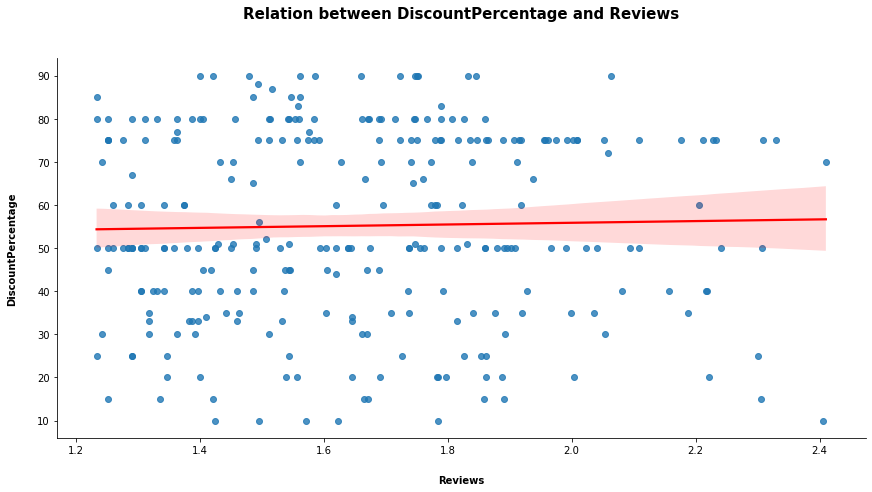

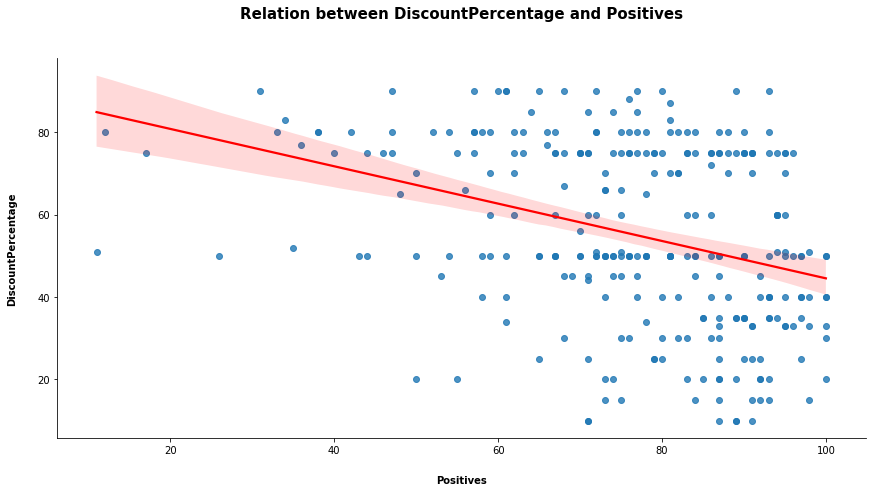

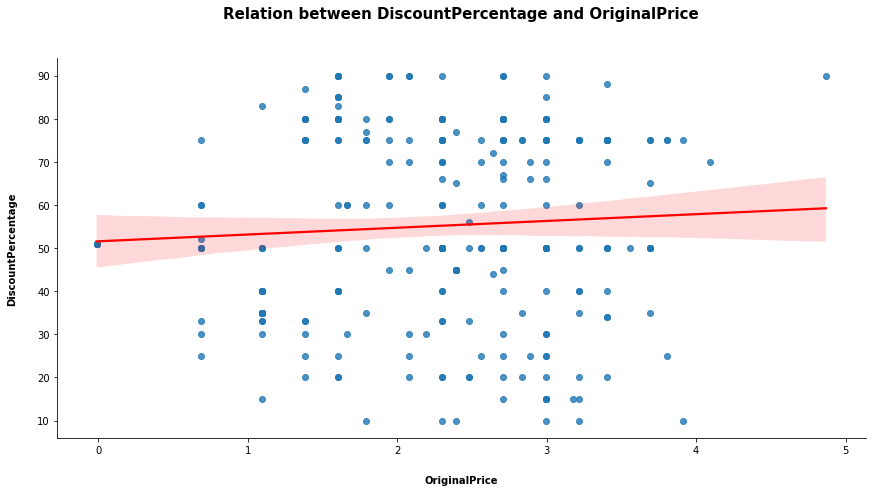

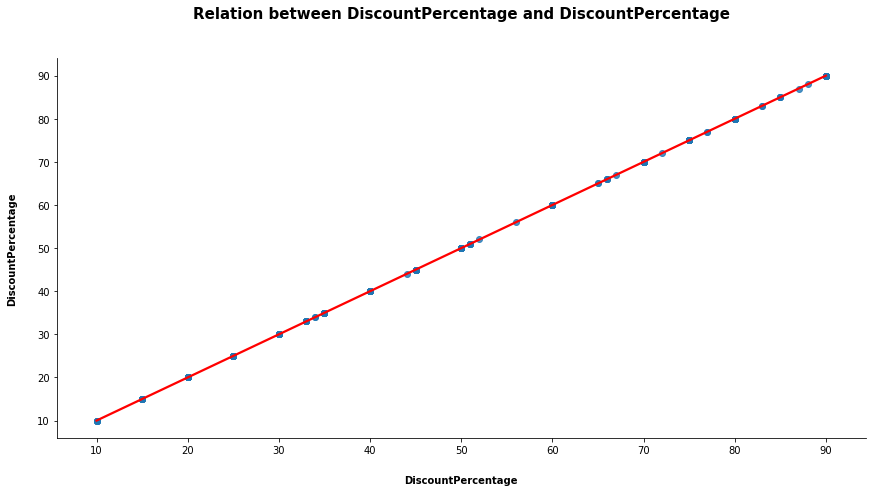

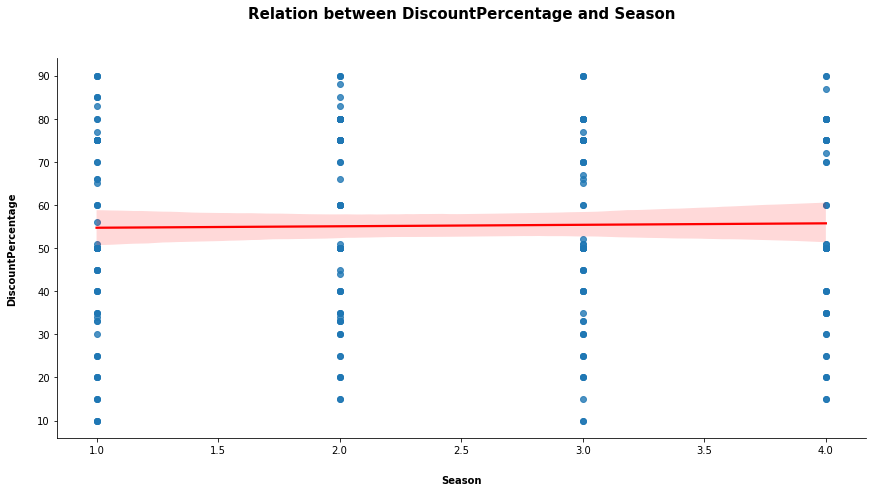

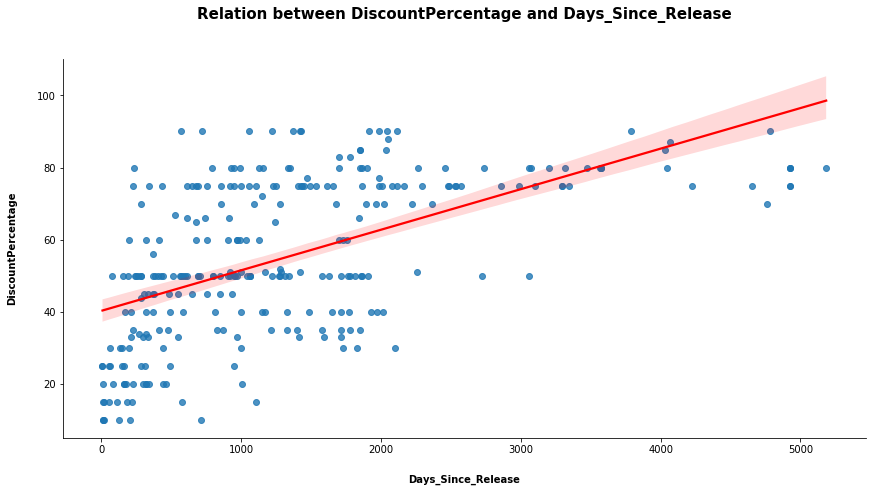

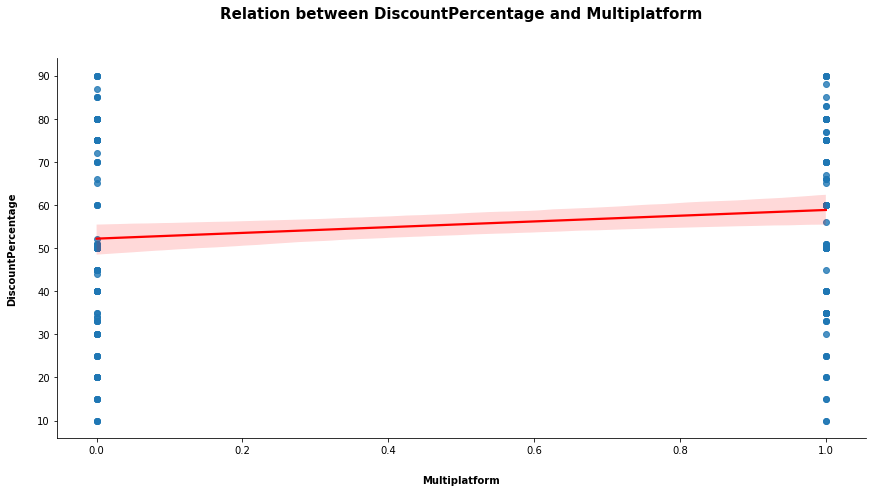

In [48]:
plotting(df2, 'DiscountPercentage')

# 2.3 F.E. and Modeling - Round 3: 
### Incorporating games' Main category as dummy data into the model
Features affected: 'Main_Tag'

In [49]:
# Copying from baseline data frame since 'Main_Tag' is dropped in df1
df3 = df.copy()

In [50]:
# Getting rid of unneeded columns
df3.drop(['Title', 'All_Tags', 'url', 'Released', 'AfterDiscount', 'Review_Summary', 'Platform'], axis=1, inplace = True)

In [51]:
df3.head()

,Reviews,Positives,OriginalPrice,DiscountPercentage,Main_Tag,Season,Days_Since_Release,Multiplatform
0,65158.00,87,49.99,10.00,Early Access,1,19.00,0
2,21555.00,87,44.99,25.00,Simulation,3,165.00,0
3,68529.00,79,59.99,70.00,Strategy,3,1276.00,1
7,22877.00,73,9.99,50.00,MMORPG,1,1060.00,0
12,28794.00,88,44.99,75.00,Simulation,3,1248.00,0


In [52]:
# Checking to make sure the dummies are separated correctly
pd.get_dummies(df3.Main_Tag).head(5)

,Action,Action Roguelike,Adventure,Anime,Board Game,Building,Card Battler,Card Game,Casual,Cats,...,Simulation,Space,Sports,Stealth,Strategy,Survival,Tower Defense,Traditional Roguelike,Turn-Based,Wargame
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [53]:
# Adding dummy categories into the dataframe
df3tagdummy = pd.concat([df3, pd.get_dummies(df3.Main_Tag).astype(int)], axis = 1)
# Drop original string based column to avoid conflict in linear regression
df3tagdummy.drop('Main_Tag', axis = 1, inplace=True)

In [54]:
df3tagdummy.head()

,Reviews,Positives,OriginalPrice,DiscountPercentage,Season,Days_Since_Release,Multiplatform,Action,Action Roguelike,Adventure,...,Simulation,Space,Sports,Stealth,Strategy,Survival,Tower Defense,Traditional Roguelike,Turn-Based,Wargame
0,65158.00,87,49.99,10.00,1,19.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21555.00,87,44.99,25.00,3,165.00,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,68529.00,79,59.99,70.00,3,1276.00,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,22877.00,73,9.99,50.00,1,1060.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,28794.00,88,44.99,75.00,3,1248.00,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


##### EDA

In [55]:
df3tagdummy.shape

(527, 44)

In [56]:
df3tagdummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 0 to 14692
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Reviews                    527 non-null    float64
 1   Positives                  527 non-null    int64  
 2   OriginalPrice              527 non-null    object 
 3   DiscountPercentage         527 non-null    float64
 4   Season                     527 non-null    int64  
 5   Days_Since_Release         527 non-null    float64
 6   Multiplatform              527 non-null    int32  
 7   Action                     527 non-null    int32  
 8   Action Roguelike           527 non-null    int32  
 9   Adventure                  527 non-null    int32  
 10  Anime                      527 non-null    int32  
 11  Board Game                 527 non-null    int32  
 12  Building                   527 non-null    int32  
 13  Card Battler               527 non-null    int32

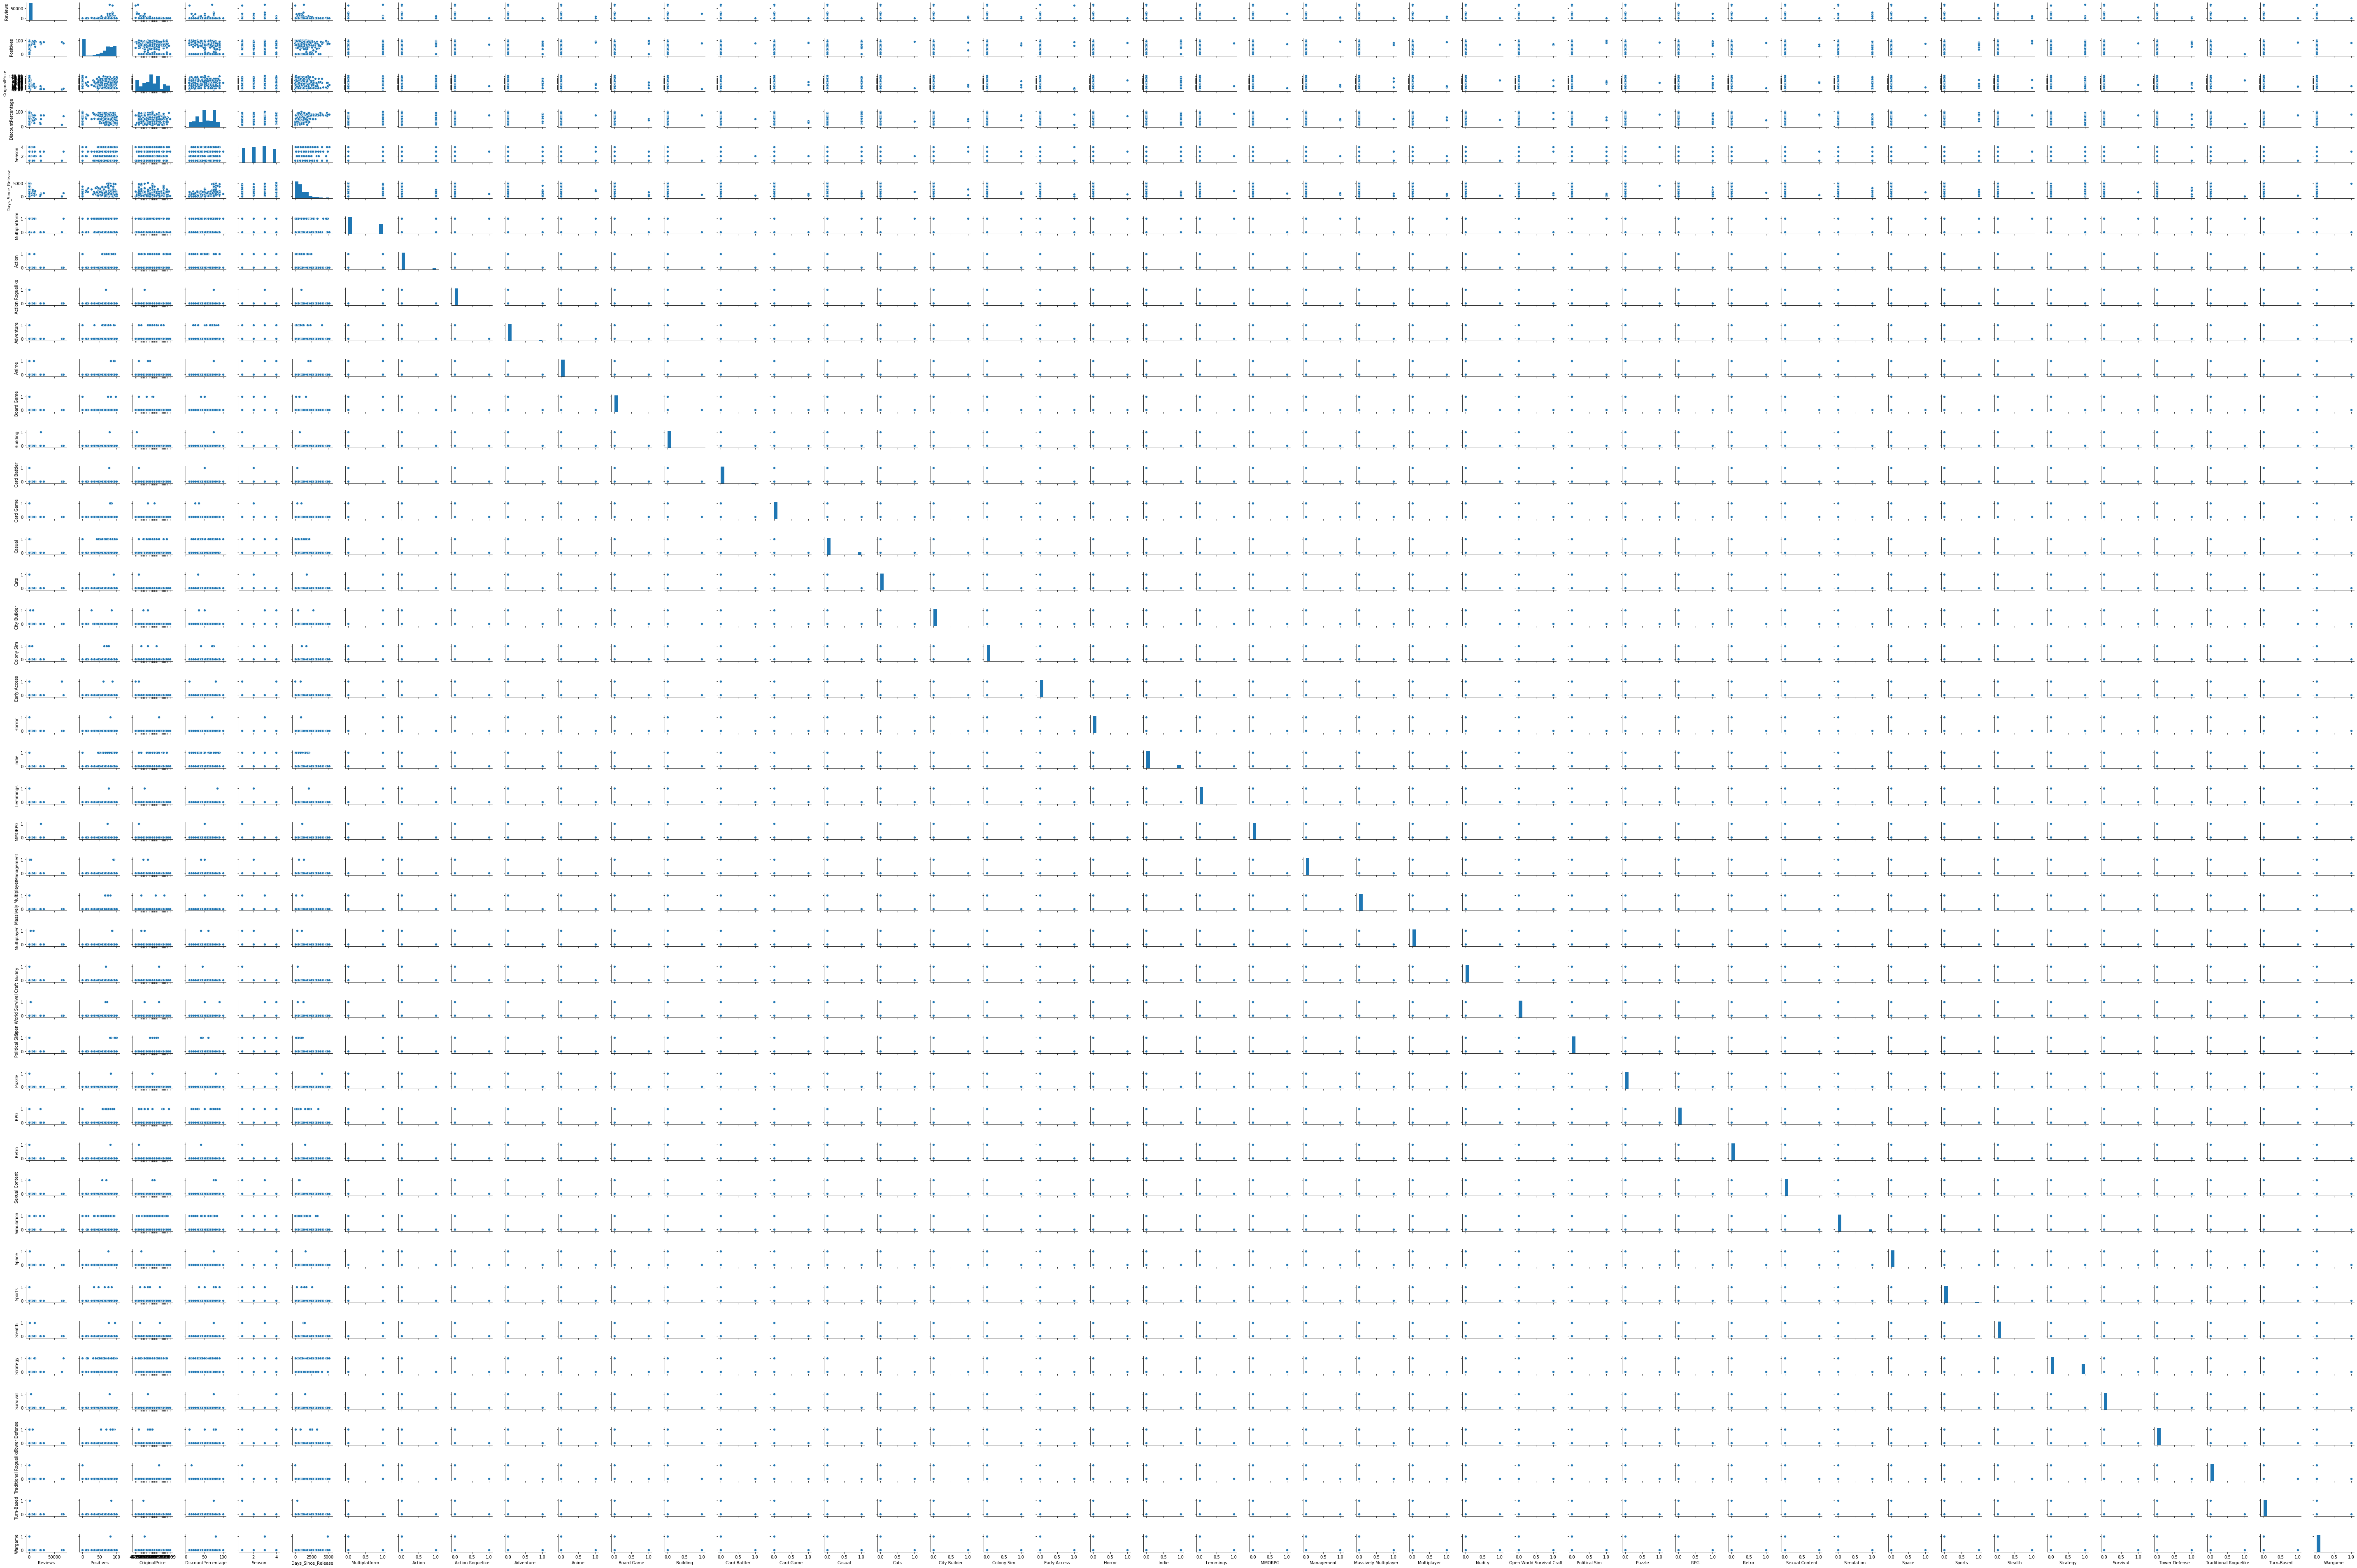

In [59]:
# Pairplotting to see outstanding correlations
sns.pairplot(df3tagdummy, height=1.2, aspect=1.5);

##### Modeling

In [57]:
RSquare(df3tagdummy, 'DiscountPercentage')

# Score is lowered due to overfitting - disproportional feature-to-data ratio

Simple regression scores:  [0.2533337624021409, 0.29300246404228036, 0.015760179830603405, 0.23913654580909371, 0.16148131076697936] 

Ridge scores:  [0.2504673379305332, 0.29549023872029867, 0.01657563901146175, 0.2433249022393692, 0.16060666603031748] 

Poly scores:  [-19.78008571572356, -246.552225885569, -12.751898500789093, -1.1467468717793556, -72930.63841067108] 

Lasso scores:  [0.2750729549211395, 0.26650323789273367, 0.07590431009771081, 0.21256291207145572, 0.24442016686864607] 

Simple mean cv r^2: 0.193 +- 0.098
Ridge mean cv r^2: 0.193 +- 0.099
Poly mean cv r^2: -14642.174 +- 29144.375 

lasso_model.alpha_: 1.0715933998226712
Lasso cv r^2: 0.330 +- 0.073 

MAE: 14.26755300968171 

RMSE: 17.387167017122454 

Lasso Coef:
[('Reviews', -0.0),
 ('Positives', -2.4530491237277907),
 ('OriginalPrice', 0.0),
 ('Season', 0.0),
 ('Days_Since_Release', 8.763861934526393),
 ('Multiplatform', 1.9742622192406951),
 ('Action', 0.0),
 ('Action Roguelike', 0.06891947311400322),
 ('Adventur

##### Plotting

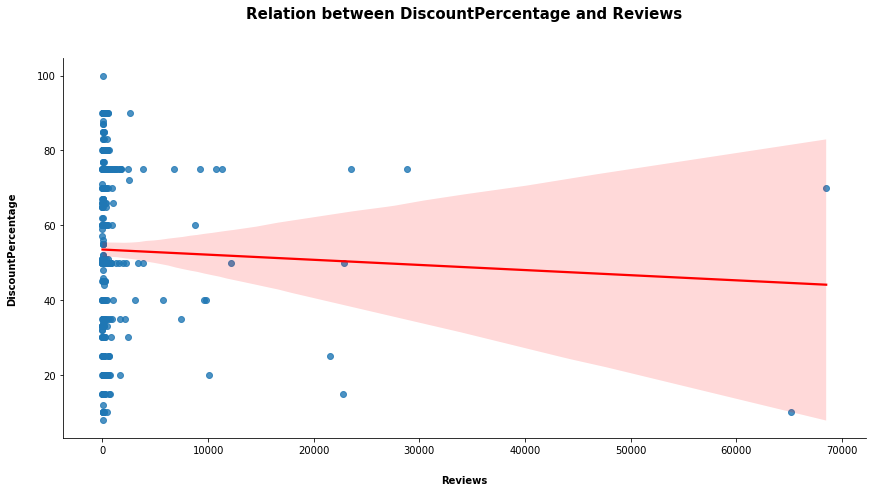

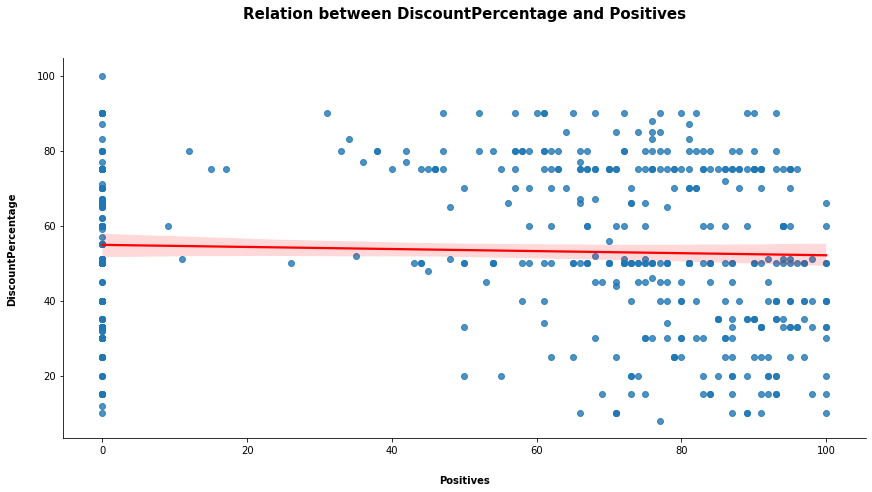

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

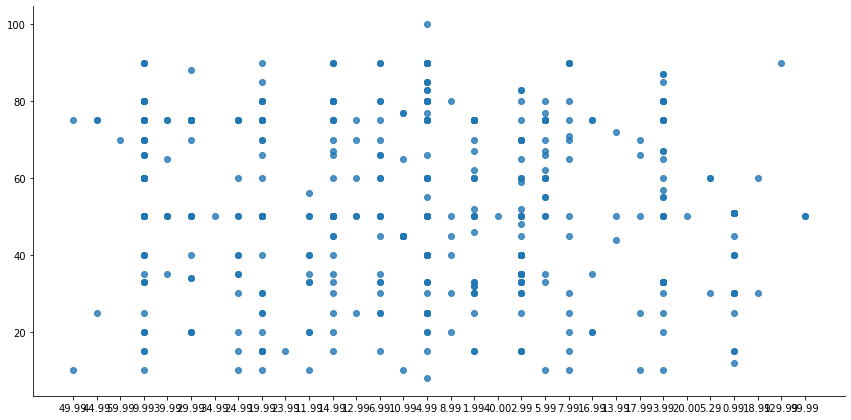

In [58]:
plotting(df3tagdummy, 'DiscountPercentage')

# 2.4 F.E. and Modeling - Round 4: 
### Incorporating games' All_Tags (based on which csv is used, top 5 tags in this case) as dummy data into the model
Features affected: 'All_Tags'

In [60]:
# Copying from baseline data frame since 'Main_Tag' is dropped in df1
df4 = df.copy()

In [63]:
# Since All_Tags is a single column with comma separated values, we first separate them
df4.All_Tags.astype(str).str.strip('[]')

0        Early Access, Medieval, Strategy, Open World, RPG
2        Simulation, Strategy, Building, Management, Sa...
3        Strategy, Turn-Based Strategy, Historical, Mul...
7        MMORPG, Massively Multiplayer, RPG, Open World...
12       Simulation, Building, Management, Sandbox, Sin...
                               ...                        
14407     Strategy, Action, Adventure, Free to Play, Indie
14413         Action, Adventure, Casual, Indie, Simulation
14466              Action, Indie, Casual, Sports, Strategy
14661             Casual, Match 3, Puzzle, Sequel, Dragons
14692    Casual, Indie, Simulation, Family Friendly, St...
Name: All_Tags, Length: 527, dtype: object

In [65]:
# The above looks correct, now we can get dummies for each tag listed
split_tag = df4.All_Tags.astype(str).str.strip('[]').str.get_dummies(', ')
split_tag

,2D,4X,Action,Action Roguelike,Action-Adventure,Adventure,Alternate History,Anime,Arcade,Assassin,...,Visual Novel,Voxel,War,Wargame,Warhammer 40K,Western,Word Game,World War I,World War II,Zombies
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14407,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14413,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14466,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
# Now merge the dummies into the data frame to start EDA
df4= pd.concat([df4, split_tag], axis=1)

In [67]:
# Drop unneeded columns
df4.drop(['Title', 'Main_Tag', 'All_Tags', 'url', 'Released', 'AfterDiscount', 'Review_Summary', 'Platform'], axis=1, inplace = True)

In [68]:
# Remove any column that only has value of 0
df4 = df4.loc[:, (df4 != 0).any(axis=0)]

##### EDA

In [69]:
df4.head()

,Reviews,Positives,OriginalPrice,DiscountPercentage,Season,Days_Since_Release,Multiplatform,2D,4X,Action,...,Visual Novel,Voxel,War,Wargame,Warhammer 40K,Western,Word Game,World War I,World War II,Zombies
0,65158.00,87,49.99,10.00,1,19.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21555.00,87,44.99,25.00,3,165.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,68529.00,79,59.99,70.00,3,1276.00,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,22877.00,73,9.99,50.00,1,1060.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,28794.00,88,44.99,75.00,3,1248.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 0 to 14692
Columns: 171 entries, Reviews to Zombies
dtypes: float64(3), int32(1), int64(166), object(1)
memory usage: 706.1+ KB


In [71]:
df4.corr()

,Reviews,Positives,DiscountPercentage,Season,Days_Since_Release,Multiplatform,2D,4X,Action,Action Roguelike,...,Visual Novel,Voxel,War,Wargame,Warhammer 40K,Western,Word Game,World War I,World War II,Zombies
Reviews,1.00,0.13,-0.03,-0.04,-0.01,0.03,-0.02,0.03,-0.06,-0.01,...,-0.01,-0.01,0.04,-0.01,-0.01,0.03,-0.01,-0.00,0.04,-0.01
Positives,0.13,1.00,-0.05,-0.07,0.14,0.26,-0.08,0.11,-0.19,0.02,...,0.03,0.03,0.04,0.06,0.03,0.02,0.00,0.05,0.08,0.02
DiscountPercentage,-0.03,-0.05,1.00,-0.02,0.49,0.14,0.09,0.10,0.07,0.04,...,0.03,-0.02,0.07,0.05,-0.01,-0.01,-0.07,0.03,0.05,0.03
Season,-0.04,-0.07,-0.02,1.00,-0.00,0.01,0.00,0.01,0.02,0.02,...,0.06,0.02,0.02,0.00,-0.06,0.06,-0.06,0.00,-0.07,-0.06
Days_Since_Release,-0.01,0.14,0.49,-0.00,1.00,0.07,-0.03,0.25,-0.02,-0.01,...,0.02,-0.01,0.11,0.14,-0.02,-0.03,-0.03,0.09,0.18,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Western,0.03,0.02,-0.01,0.06,-0.03,-0.03,-0.00,-0.01,-0.02,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,-0.00,-0.00,-0.01,-0.00
Word Game,-0.01,0.00,-0.07,-0.06,-0.03,0.06,-0.00,-0.01,-0.02,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,-0.00,-0.01,-0.00
World War I,-0.00,0.05,0.03,0.00,0.09,0.02,-0.01,-0.01,-0.03,-0.00,...,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,1.00,0.23,-0.00
World War II,0.04,0.08,0.05,-0.07,0.18,-0.04,-0.01,-0.02,0.03,-0.01,...,-0.01,-0.01,0.33,-0.01,-0.01,-0.01,-0.01,0.23,1.00,-0.01


##### Modeling

In [73]:
RSquare(df4, 'DiscountPercentage')
# Conclusion on which tags are most impactful can be drawn from observing the lasso coefs

Simple regression scores:  [-7128247344966802.0, -8.771357483864878e+16, -0.3320258786086199, -0.4309916711533137, -0.21048053591839566] 

Ridge scores:  [-0.27683457434214986, -0.5812459284781877, -0.31814598058572785, -0.38412050347876625, -0.18772049987239248] 

Poly scores:  [-2012433161.594026, -51278804525.81663, -7632554078.912456, -76257045.81546801, -180452146772.44937] 

Lasso scores:  [0.189504738350196, 0.30685524198914127, 0.0671366936938792, 0.2278351654268268, 0.2533147626862977] 

Simple mean cv r^2: -18968364436723116.000 +- 34483297041218536.000
Ridge mean cv r^2: -0.350 +- 0.132
Poly mean cv r^2: -48290439116.918 +- 68694937370.949 

lasso_model.alpha_: 0.7760503335133571
Lasso cv r^2: 0.359 +- 0.080 

MAE: 13.897835587448206 

RMSE: 17.00874574747042 

Lasso Coef:
[('Reviews', -0.0),
 ('Positives', -1.1773950821568093),
 ('OriginalPrice', 0.0),
 ('Season', -0.0),
 ('Days_Since_Release', 9.25070247708177),
 ('Multiplatform', 2.026243906729473),
 ('2D', 2.137788067761

##### Due to the amount features (170), plotting is not feasible

# 2.5 F.E. and Modeling - Round 5: 
### Combine Log Transformation with dummy tag to see if there is any improvements
Features affected: 'All_Tags', 'Reviews'

In [74]:
df5 = df.copy()

In [75]:
# Dummy all top 5 tags
split_tag = df.All_Tags.astype(str).str.strip('[]').str.get_dummies(', ')
df5= pd.concat([df5, split_tag], axis=1)

In [76]:
# Log transform Review due to skewed pairplot graphs
df5['Log_Review'] = np.log(df5['Reviews'])

In [77]:
df5.drop(['Title', 'Main_Tag', 'Reviews', 'All_Tags', 'url', 'Released', 'AfterDiscount', 'Review_Summary', 'Platform'], axis=1, inplace = True)

##### EDA

In [79]:
df5.head()

,Positives,OriginalPrice,DiscountPercentage,Season,Days_Since_Release,Multiplatform,2D,4X,Action,Action Roguelike,...,Voxel,War,Wargame,Warhammer 40K,Western,Word Game,World War I,World War II,Zombies,Log_Review
0,87,49.99,10.00,1,19.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11.08
2,87,44.99,25.00,3,165.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.98
3,79,59.99,70.00,3,1276.00,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11.14
7,73,9.99,50.00,1,1060.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.04
12,88,44.99,75.00,3,1248.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.27


In [80]:
df5.corr()

,Positives,DiscountPercentage,Season,Days_Since_Release,Multiplatform,2D,4X,Action,Action Roguelike,Action-Adventure,...,Voxel,War,Wargame,Warhammer 40K,Western,Word Game,World War I,World War II,Zombies,Log_Review
Positives,1.00,-0.05,-0.07,0.14,0.26,-0.08,0.11,-0.19,0.02,-0.09,...,0.03,0.04,0.06,0.03,0.02,0.00,0.05,0.08,0.02,0.72
DiscountPercentage,-0.05,1.00,-0.02,0.49,0.14,0.09,0.10,0.07,0.04,0.06,...,-0.02,0.07,0.05,-0.01,-0.01,-0.07,0.03,0.05,0.03,0.08
Season,-0.07,-0.02,1.00,-0.00,0.01,0.00,0.01,0.02,0.02,0.09,...,0.02,0.02,0.00,-0.06,0.06,-0.06,0.00,-0.07,-0.06,-0.09
Days_Since_Release,0.14,0.49,-0.00,1.00,0.07,-0.03,0.25,-0.02,-0.01,-0.06,...,-0.01,0.11,0.14,-0.02,-0.03,-0.03,0.09,0.18,0.04,0.25
Multiplatform,0.26,0.14,0.01,0.07,1.00,0.03,0.10,-0.02,0.06,-0.05,...,-0.03,-0.07,-0.05,-0.03,-0.03,0.06,0.02,-0.04,-0.01,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Word Game,0.00,-0.07,-0.06,-0.03,0.06,-0.00,-0.01,-0.02,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,-0.00,-0.01,-0.00,0.00
World War I,0.05,0.03,0.00,0.09,0.02,-0.01,-0.01,-0.03,-0.00,-0.00,...,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,1.00,0.23,-0.00,0.07
World War II,0.08,0.05,-0.07,0.18,-0.04,-0.01,-0.02,0.03,-0.01,-0.01,...,-0.01,0.33,-0.01,-0.01,-0.01,-0.01,0.23,1.00,-0.01,0.14
Zombies,0.02,0.03,-0.06,0.04,-0.01,-0.01,-0.01,0.08,-0.00,-0.00,...,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,1.00,0.06


##### Modeling

In [81]:
RSquare(df5, 'DiscountPercentage')
# Conclusion on which tags are most impactful can be drawn from observing the lasso coefs

Simple regression scores:  [-4.257535433861785e+16, -4.798992146801902e+18, -3491680722504380.5, -1.2439506998979051e+17, -0.26318859276763384] 

Ridge scores:  [-0.1266411869333821, -0.27515001478547196, -0.33175576547159036, -0.3828072896506647, -0.23990823481648893] 

Poly scores:  [-1793.3622369283214, -9316.170519470326, -7618.240015741787, -977.6244495796471, -756459.3716069857] 

Lasso scores:  [0.1895049784452998, 0.30685524198914127, 0.0671366936938792, 0.2278351654268268, 0.2533147921768588] 

Simple mean cv r^2: -993890850370562816.000 +- 1903078006750317568.000
Ridge mean cv r^2: -0.271 +- 0.087
Poly mean cv r^2: -155232.954 +- 300630.481 

lasso_model.alpha_: 0.7760503335133571
Lasso cv r^2: 0.359 +- 0.080 

MAE: 13.897826561498963 

RMSE: 17.008742904160204 

Lasso Coef:
[('Positives', -1.1773905359755683),
 ('OriginalPrice', 0.0),
 ('Season', -0.0),
 ('Days_Since_Release', 9.250705135948243),
 ('Multiplatform', 2.026240849097345),
 ('2D', 2.1377887982978794),
 ('4X', 0.0

##### Due to the amount features (170), plotting is not feasible

# 2.6 F.E. and Modeling - Round 6: 
### Binning features to reduce the effects of minor observation errors
Features affected: 'Positives', 'Reviews'

In [108]:
# Copying from the baseline dataset to include outliers in the bins
df6 = df.copy()

In [109]:
df6.head()

,Title,Platform,Reviews,Positives,Review_Summary,Released,OriginalPrice,DiscountPercentage,AfterDiscount,Main_Tag,url,All_Tags,Season,Days_Since_Release,Multiplatform
0,Mount & Blade II: Bannerlord,Win,65158.00,87,Very Positive,2020-03-30,49.99,10.00,44.99,Early Access,https://store.steampowered.com/app/261550/Moun...,"Early Access, Medieval, Strategy, Open World, RPG",1,19.00,0
2,Planet Zoo,Win,21555.00,87,Very Positive,2019-11-05,44.99,25.00,33.74,Simulation,https://store.steampowered.com/app/703080/Plan...,"Simulation, Strategy, Building, Management, Sa...",3,165.00,0
3,Sid Meier’s Civilization® VI,"Win, Mac, Linux",68529.00,79,Mostly Positive,2016-10-20,59.99,70.00,17.99,Strategy,https://store.steampowered.com/app/289070/Sid_...,"Strategy, Turn-Based Strategy, Historical, Mul...",3,1276.00,1
7,Black Desert Online,Win,22877.00,73,Mostly Positive,2017-05-24,9.99,50.00,4.99,MMORPG,https://store.steampowered.com/app/582660/Blac...,"MMORPG, Massively Multiplayer, RPG, Open World...",1,1060.00,0
12,Planet Coaster,Win,28794.00,88,Very Positive,2016-11-17,44.99,75.00,11.24,Simulation,https://store.steampowered.com/app/493340/Plan...,"Simulation, Building, Management, Sandbox, Sin...",3,1248.00,0


In [110]:
df6.drop(df6.loc[df6['Positives']==0].index, inplace=True)

In [111]:
df6.dropna()

,Title,Platform,Reviews,Positives,Review_Summary,Released,OriginalPrice,DiscountPercentage,AfterDiscount,Main_Tag,url,All_Tags,Season,Days_Since_Release,Multiplatform
0,Mount & Blade II: Bannerlord,Win,65158.00,87,Very Positive,2020-03-30,49.99,10.00,44.99,Early Access,https://store.steampowered.com/app/261550/Moun...,"Early Access, Medieval, Strategy, Open World, RPG",1,19.00,0
2,Planet Zoo,Win,21555.00,87,Very Positive,2019-11-05,44.99,25.00,33.74,Simulation,https://store.steampowered.com/app/703080/Plan...,"Simulation, Strategy, Building, Management, Sa...",3,165.00,0
3,Sid Meier’s Civilization® VI,"Win, Mac, Linux",68529.00,79,Mostly Positive,2016-10-20,59.99,70.00,17.99,Strategy,https://store.steampowered.com/app/289070/Sid_...,"Strategy, Turn-Based Strategy, Historical, Mul...",3,1276.00,1
7,Black Desert Online,Win,22877.00,73,Mostly Positive,2017-05-24,9.99,50.00,4.99,MMORPG,https://store.steampowered.com/app/582660/Blac...,"MMORPG, Massively Multiplayer, RPG, Open World...",1,1060.00,0
12,Planet Coaster,Win,28794.00,88,Very Positive,2016-11-17,44.99,75.00,11.24,Simulation,https://store.steampowered.com/app/493340/Plan...,"Simulation, Building, Management, Sandbox, Sin...",3,1248.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6546,16bit Trader,"Win, Mac, Linux",399.00,34,Mostly Negative,2015-06-04,2.99,83.00,0.50,Simulation,https://store.steampowered.com/app/375460/16bi...,"Simulation, Indie, Strategy, Casual, RPG",1,1780.00,1
6552,Luxury Hotel Emporium,Win,11.00,9,Negative,2015-08-07,4.99,60.00,1.99,Simulation,https://store.steampowered.com/app/389680/Luxu...,"Simulation, Strategy",2,1716.00,0
6707,Project Tarvotan,"Win, Mac",13.00,15,Negative,2015-09-25,1.99,75.00,0.49,Strategy,https://store.steampowered.com/app/388660/Proj...,"Strategy, Indie, Simulation, Space, Turn-Based...",3,1667.00,1
6766,Remaining in a dream,Win,91.00,35,Mostly Negative,2016-10-15,1.99,52.00,0.95,Adventure,https://store.steampowered.com/app/542430/Rema...,"Adventure, Indie, Strategy, Puzzle, First-Person",3,1281.00,0


In [112]:
# Drop unused columns
df6.drop(['Title', 'Main_Tag', 'All_Tags', 'url', 'Released', 'AfterDiscount', 'Review_Summary', 'Platform'], axis=1, inplace = True)

##### EDA

In [113]:
df6.describe()

,Reviews,Positives,DiscountPercentage,Season,Days_Since_Release,Multiplatform
count,370.00,370.00,370.00,370.00,370.00,370.00
mean,1242.60,75.83,54.32,2.43,1214.42,0.45
std,5790.92,17.18,22.14,1.07,1058.40,0.50
min,10.00,9.00,8.00,1.00,8.00,0.00
25%,33.00,67.00,36.25,2.00,418.00,0.00
50%,93.00,78.00,50.00,2.00,947.00,0.00
75%,381.50,89.00,75.00,3.00,1716.75,1.00
max,68529.00,100.00,90.00,4.00,5184.00,1.00


In [114]:
# Binning reviews (which is highly correlated with popularity) based on the above 75 percentile and 25 percentile
df6.loc[df6['Reviews'] < 30, 'low_pop'] = 1
df6.loc[(df6.Reviews >= 30) & (df6.Reviews < 194), 'mid_pop'] = 1
df6.loc[df6['Reviews'] >= 194, 'high_pop'] = 1

In [115]:
# Binning Days_Since_Release based on the above 75 percentile and 25 percentile
df6.loc[df6['Days_Since_Release'] < 90, 'new_game'] = 1
df6.loc[(df6.Days_Since_Release >= 90) & (df6.Days_Since_Release < 1460), 'established_game'] = 1
df6.loc[df6['Days_Since_Release'] >= 1460, 'old_game'] = 1

In [116]:
df6.fillna(0, inplace = True)

In [117]:
df6.drop(['Reviews', 'Days_Since_Release'], axis=1, inplace = True)

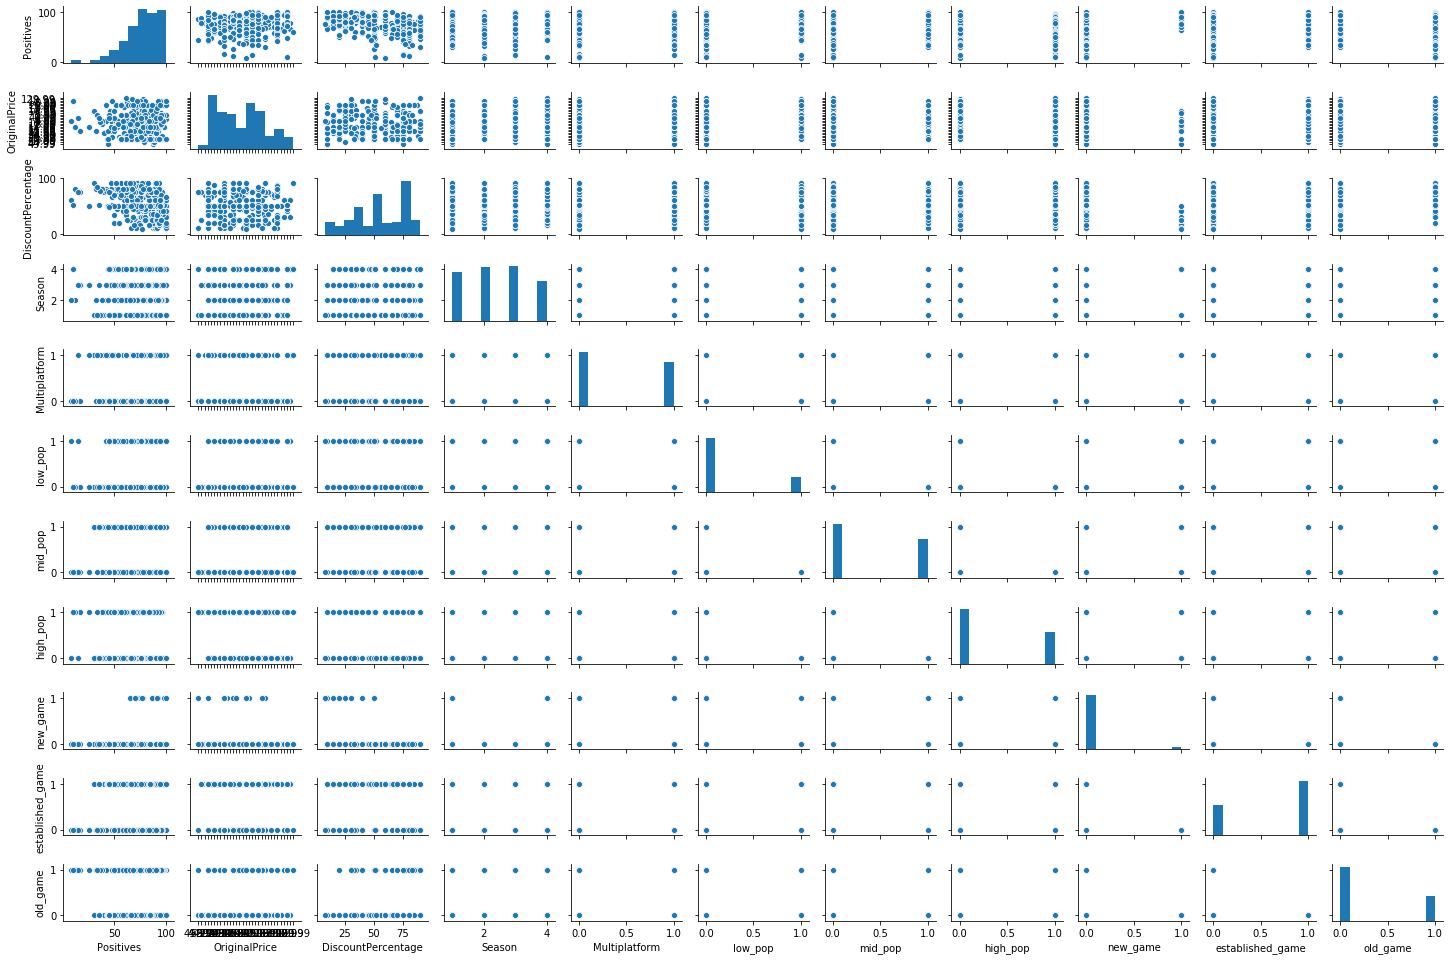

In [118]:
sns.pairplot(df6, height=1.2, aspect=1.5);

##### Modeling

In [119]:
RSquare(df6, 'DiscountPercentage')

# Based on the coefficient, it appears again, that popularity has nothing to do with % discount

Simple regression scores:  [0.26737157319276583, 0.2080485608283613, 0.3450751915141561, 0.25569807086960694, 0.28720329745307904] 

Ridge scores:  [0.2677115038545178, 0.20848323961299198, 0.34465386145445126, 0.25575531870106594, 0.2874937392798236] 

Poly scores:  [0.10241966961526494, -2.455784226066121, 0.04030451139497571, 0.11588551118559876, 0.16210381286366826] 

Lasso scores:  [0.2991205567794202, 0.19843442547346968, 0.3317336115317973, 0.26696364773609005, 0.2909440780221747] 

Simple mean cv r^2: 0.273 +- 0.045
Ridge mean cv r^2: 0.273 +- 0.044
Poly mean cv r^2: -0.407 +- 1.025 

lasso_model.alpha_: 0.707701066118189
Lasso cv r^2: 0.219 +- 0.045 

MAE: 16.382131128788647 

RMSE: 19.732249284704587 

Lasso Coef:
[('Positives', -4.373898259492096),
 ('OriginalPrice', 0.3972232765021781),
 ('Season', 0.0),
 ('Multiplatform', 1.0854745505848709),
 ('low_pop', 0.0),
 ('mid_pop', -0.0),
 ('high_pop', 0.0),
 ('new_game', -4.931387918529547),
 ('established_game', -0.0),
 ('old_ga

##### Plotting

In [121]:
# plotting(df6, 'DiscountPercentage')
# Not necessary due to the amount of dummy columns (7 out of 11)

# 2.7 F.E. and Modeling - Round 7: 
### Binning in two brackets rather than 3, also removing some floor outliers
Features affected: 'Positives', 'Reviews'

In [122]:
df7 = df.copy()

In [123]:
df7.head()

,Title,Platform,Reviews,Positives,Review_Summary,Released,OriginalPrice,DiscountPercentage,AfterDiscount,Main_Tag,url,All_Tags,Season,Days_Since_Release,Multiplatform
0,Mount & Blade II: Bannerlord,Win,65158.00,87,Very Positive,2020-03-30,49.99,10.00,44.99,Early Access,https://store.steampowered.com/app/261550/Moun...,"Early Access, Medieval, Strategy, Open World, RPG",1,19.00,0
2,Planet Zoo,Win,21555.00,87,Very Positive,2019-11-05,44.99,25.00,33.74,Simulation,https://store.steampowered.com/app/703080/Plan...,"Simulation, Strategy, Building, Management, Sa...",3,165.00,0
3,Sid Meier’s Civilization® VI,"Win, Mac, Linux",68529.00,79,Mostly Positive,2016-10-20,59.99,70.00,17.99,Strategy,https://store.steampowered.com/app/289070/Sid_...,"Strategy, Turn-Based Strategy, Historical, Mul...",3,1276.00,1
7,Black Desert Online,Win,22877.00,73,Mostly Positive,2017-05-24,9.99,50.00,4.99,MMORPG,https://store.steampowered.com/app/582660/Blac...,"MMORPG, Massively Multiplayer, RPG, Open World...",1,1060.00,0
12,Planet Coaster,Win,28794.00,88,Very Positive,2016-11-17,44.99,75.00,11.24,Simulation,https://store.steampowered.com/app/493340/Plan...,"Simulation, Building, Management, Sandbox, Sin...",3,1248.00,0


In [124]:
df7.describe()

,Reviews,Positives,DiscountPercentage,AfterDiscount,Season,Days_Since_Release,Multiplatform
count,527.00,527.00,527.00,527.00,527.00,527.00,527.00
mean,873.58,53.24,53.39,4.99,2.48,1085.01,0.37
std,4883.33,37.58,21.65,5.99,1.09,996.96,0.48
min,1.00,0.00,8.00,0.00,1.00,7.00,0.00
25%,6.00,0.00,35.00,1.39,2.00,358.50,0.00
50%,38.00,69.00,50.00,2.99,2.00,801.00,0.00
75%,203.00,85.00,75.00,6.44,3.00,1562.00,1.00
max,68529.00,100.00,100.00,49.99,4.00,5184.00,1.00


In [125]:
df7 = df7.dropna()

In [126]:
df7.drop(df7.loc[df7['Positives']==0].index, inplace=True)

In [127]:
df7.drop(['Title', 'Main_Tag', 'All_Tags', 'url', 'Released', 'AfterDiscount', 'Review_Summary', 'Platform'], axis=1, inplace = True)

In [128]:
df7 = df7[df7.Reviews > 30]

##### EDA

In [134]:
df7.describe()

,Positives,DiscountPercentage,Season,Multiplatform,low_pop,high_pop,new_game,old_game
count,287.00,287.00,287.00,287.00,287.00,287.00,287.00,287.00
mean,76.49,55.18,2.36,0.45,0.59,0.41,0.54,0.46
std,16.67,21.87,1.08,0.50,0.49,0.49,0.50,0.50
min,11.00,10.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,68.00,40.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,79.00,50.00,2.00,0.00,1.00,0.00,1.00,0.00
75%,89.50,75.00,3.00,1.00,1.00,1.00,1.00,1.00
max,100.00,90.00,4.00,1.00,1.00,1.00,1.00,1.00


In [130]:
df7.loc[df7['Reviews'] < 271, 'low_pop'] = 1
df7.loc[df7['Reviews'] >= 271, 'high_pop'] = 1

df7.loc[df7['Days_Since_Release'] < 1167, 'new_game'] = 1
df7.loc[df7['Days_Since_Release'] >= 1167, 'old_game'] = 1

In [132]:
df7.fillna(0, inplace= True)

In [133]:
df7.drop(['Reviews', 'Days_Since_Release'], axis=1, inplace = True)

In [138]:
df7.corr()

,Positives,DiscountPercentage,Season,Multiplatform,low_pop,high_pop,new_game,old_game
Positives,1.00,-0.35,0.02,0.02,-0.02,0.02,0.16,-0.16
DiscountPercentage,-0.35,1.00,0.02,0.15,-0.05,0.05,-0.47,0.47
Season,0.02,0.02,1.00,0.06,-0.01,0.01,-0.06,0.06
Multiplatform,0.02,0.15,0.06,1.00,-0.21,0.21,-0.14,0.14
low_pop,-0.02,-0.05,-0.01,-0.21,1.00,-1.00,0.13,-0.13
high_pop,0.02,0.05,0.01,0.21,-1.00,1.00,-0.13,0.13
new_game,0.16,-0.47,-0.06,-0.14,0.13,-0.13,1.00,-1.00
old_game,-0.16,0.47,0.06,0.14,-0.13,0.13,-1.00,1.00


##### Modeling

In [136]:
RSquare(df7, 'DiscountPercentage')

Simple regression scores:  [0.24637176671186634, 0.29912251012403, -0.014935088967510614, 0.29208534807095143, 0.25498899134558173] 

Ridge scores:  [0.24705531846322737, 0.2991423845692802, -0.013919902117485838, 0.2924276205294516, 0.25453797494393593] 

Poly scores:  [0.0408211870470645, 0.2397701831894381, -1.2203654473732444, -0.15338689280195306, 0.06952573972122533] 

Lasso scores:  [0.27198293502738513, 0.3093971520880716, 0.04096718588541892, 0.2908290615561572, 0.21849359376688815] 

Simple mean cv r^2: 0.216 +- 0.117
Ridge mean cv r^2: 0.216 +- 0.117
Poly mean cv r^2: -0.205 +- 0.523 

lasso_model.alpha_: 1.5494950393146316
Lasso cv r^2: 0.313 +- 0.098 

MAE: 14.461653983057246 

RMSE: 17.74970221903066 

Lasso Coef:
[('Positives', -3.430312044044582),
 ('OriginalPrice', 0.0),
 ('Season', -0.0),
 ('Multiplatform', 0.0),
 ('low_pop', -0.0),
 ('high_pop', 0.0),
 ('new_game', -8.093264169403103),
 ('old_game', 1.8535897454611336e-15)]


##### Plotting

In [139]:
# Not necessary due to the amount of dummy columns (5 out of 8)

# 3.1 Conclusion: 
### Determine best model

###### Best score for each round:
    df1: Lasso cv r^2: 0.419 +- 0.073 
    df2: Lasso cv r^2: 0.437 +- 0.104
    df3: Lasso cv r^2: 0.330 +- 0.073
    df4: Lasso cv r^2: 0.359 +- 0.080
    df5: Lasso cv r^2: 0.359 +- 0.080
    df6: Ridge mean cv r^2: 0.273 +- 0.044
    df7: Lasso cv r^2: 0.313 +- 0.098

##### Best model is the baseline model (df1) with r^2: 0.419 +- 0.073 